In [1]:
import os
import glob
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt

from osprey.means.eof import preproc_pattern_3D, preproc_timeseries_3D
from osprey.actions.reader import elements
from osprey.utils.folders import folders
from osprey.means.means import timemean
from osprey.utils.time import get_startleg, get_year
from osprey.utils import run_cdo
from osprey.actions.forecaster import forecaster_EOF_winter

In [2]:
expname = "FE00"
var = "thetao"
ndim ="3D"
endleg = 10
yearspan = 5
yearleap = 10
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1
dirs = folders(expname)

In [26]:
run_cdo.merge_winter(expname, var, startyear, endyear)

File /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc not found.
Command: 'cdo cat /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1994-1994.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1993-1993.nc /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lat_grid_T_inner<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lon_grid_T_inner<
cdi  warning (find_time_vars): Found more than one time variable, skipped variable time_centered!
cdi  warning (cdfInqContents): Coordinates variable time_centered can't be assigned!
cdi  warning (cdfSca

In [27]:
run_cdo.detrend(expname, var, endleg)
run_cdo.get_EOF(expname, var, endleg, window)

File /ec/res4/scratch/itas/martini/FE00/010/thetao_anomaly.nc successfully removed.
Command: 'cdo sub /ec/res4/scratch/itas/martini/FE00/010/thetao.nc -timmean /ec/res4/scratch/itas/martini/FE00/010/thetao.nc /ec/res4/scratch/itas/martini/FE00/010/thetao_anomaly.nc' 
cdo    sub: Filling up stream2 >(pipe1.4)< by copying the first timestep.

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

 Time window  5
File /ec/res4/scratch/itas/martini/FE00/010/thetao_variance.nc successfully removed.
File /ec/res4/scratch/itas/martini/FE00/010/thetao_pattern.nc successfully removed.
Command: 'cdo eof3d,5 /ec/res4/scratch/itas/martini/FE00/010/thetao_anomaly.nc /ec/res4/scratch/itas/martini/FE00/010/the

In [28]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
data = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)

In [29]:
data['time'].values

array([cftime.DatetimeGregorian(1994, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1995, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1996, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1996, 12, 31, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1998, 1, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [30]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")    
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    #p = timeseries.polyfit(dim='time', deg=1, skipna = True)
    # theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    theta = timeseries[var].isel(time=-1)
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.drop_vars({'time'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

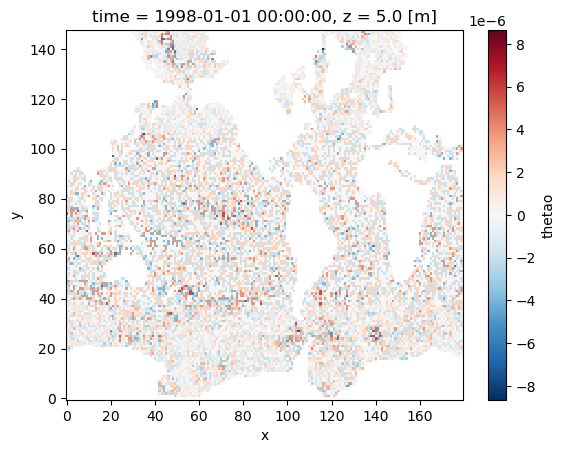

In [31]:
delta = xdata[var].isel(time=-1,z=0)-total[var].isel(z=0)
delta.plot()

In [32]:
df = elements(expname)
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

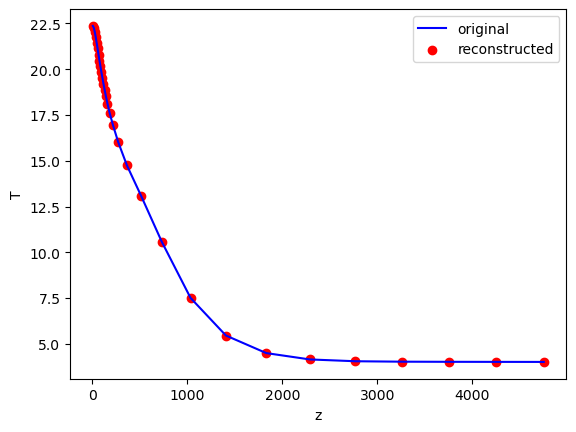

In [33]:
plt.plot(rpa['z'].values,fpa.values, color='b', label='original')
plt.scatter(fpa['z'].values,fpa.values, color='r', label='reconstructed')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T difference')

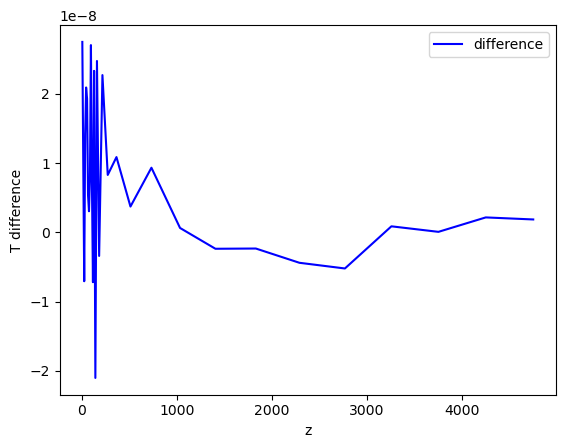

In [34]:
plt.plot(rpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

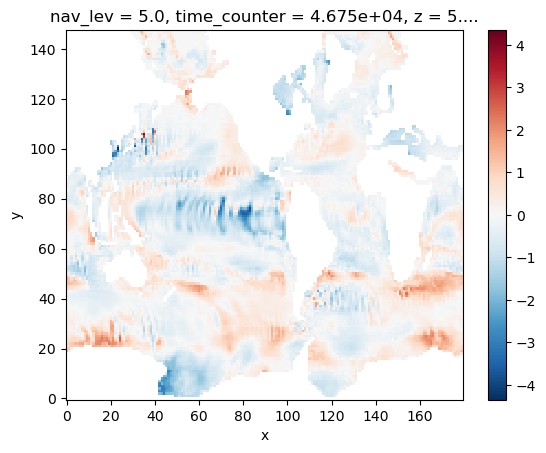

In [35]:
filename = os.path.join(dirs['tmp'], str(endleg-1).zfill(3), "FE00_*_restart.nc")
rdata = xr.open_mfdataset(filename, use_cftime=True)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-total[var].isel(z=0)
delta.plot()

In [36]:
rpa = rdata['tn'].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T difference')

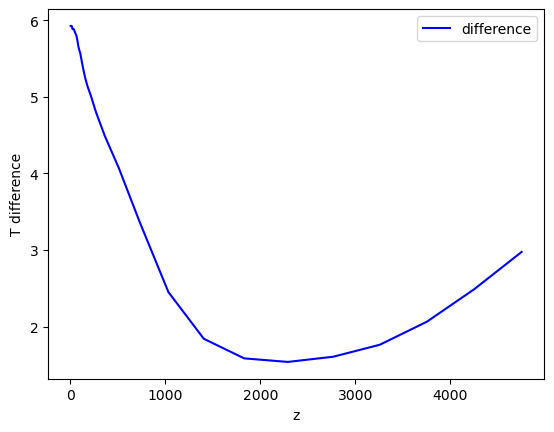

In [37]:
plt.plot(fpa['z'].values,fpa.values-rpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [28]:
# try the forecaster function

In [3]:
rdata = forecaster_EOF_winter(expname, var, endleg, yearspan, yearleap)

File /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc not found.
Command: 'cdo cat /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1994-1994.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1993-1993.nc /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lat_grid_T_inner<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lon_grid_T_inner<
cdi  warning (find_time_vars): Found more than one time variable, skipped variable time_centered!
cdi  warning (cdfInqContents): Coordinates variable time_centered can't be assigned!
cdi  warning (cdfSca

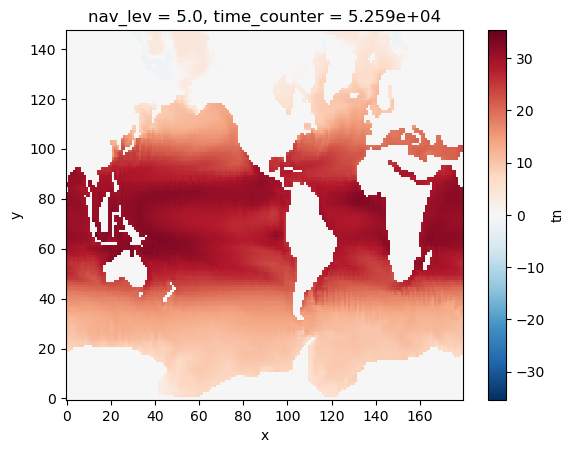

In [6]:
rdata['tn'].isel(time_counter=0,nav_lev=0).plot()

In [39]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)

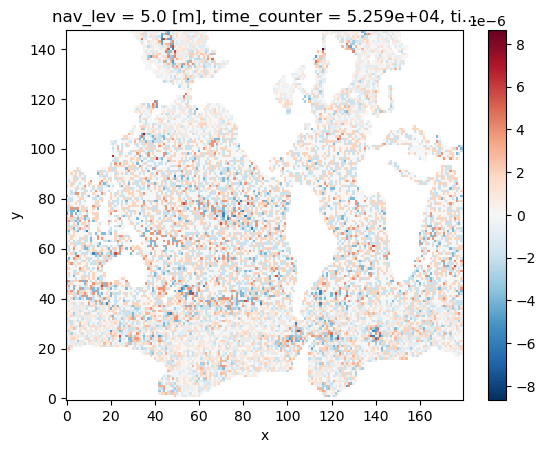

In [40]:
#delta = rdata['tn'].isel(time_counter=-1,nav_lev=0)-rrdata['tn'].isel(time_counter=-1,nav_lev=0)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-xdata[var].isel(time=-1,z=0)
delta.plot()

In [6]:
# try the entire procedure from command line, load only the restart files

In [7]:
# we can try to reconstruct the restart, by projecting thetao six months in the future (do the same thing for the FIT procedure!)
# or maybe try with another thetao field in the future...

In [41]:
# using fit to reconstruct year 1999
fdate = cftime.DatetimeGregorian(1999, 1, 1, 0, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    p = timeseries.polyfit(dim='time', deg=2, skipna = True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.isel(time=0)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

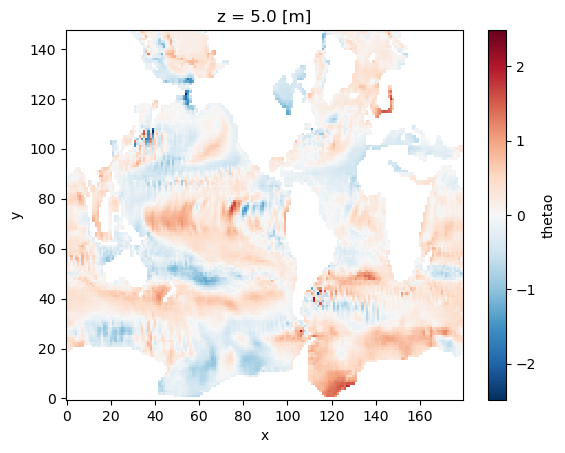

In [42]:
delta = xdata['thetao'].isel(time=-1,z=0) - total['thetao'].isel(z=0)
delta.plot()

Text(0, 0.5, 'T difference')

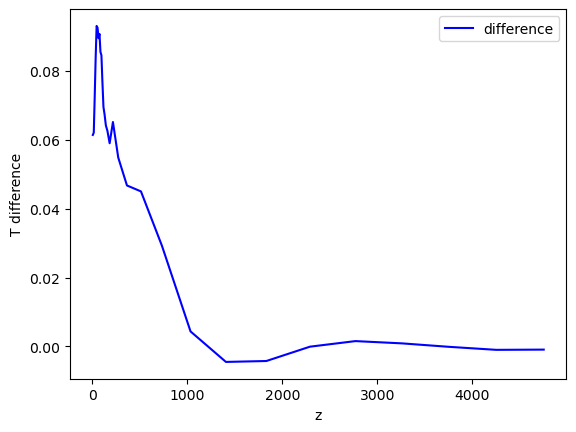

In [43]:
df = elements(expname)
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])
plt.plot(rpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [44]:
# using fit to reconstuct year 2000
fdate = cftime.DatetimeGregorian(2000, 1, 1, 0, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    timeseries[var] = timeseries[var].astype(np.float64)
    p = timeseries.polyfit(dim='time', deg=8, skipna = True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.isel(time=0)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

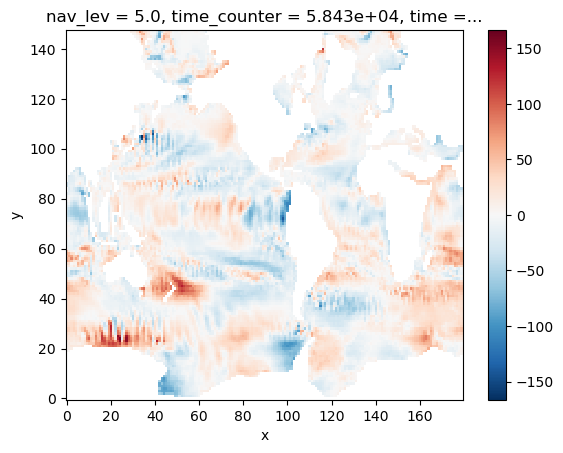

In [45]:
filename = os.path.join(dirs['tmp'], str(endleg+1).zfill(3), "FE00_*_restart.nc")
rdata = xr.open_mfdataset(filename, use_cftime=True)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-total[var].isel(z=0)
delta.plot()

Text(0, 0.5, 'T difference')

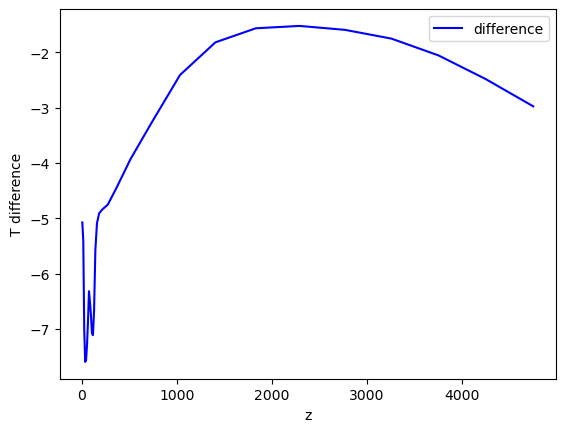

In [46]:
df = elements(expname)
rpa = rdata['tn'].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])
plt.plot(fpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')